In [2]:
import pickle

import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv

In [4]:
print("Loading data...")
training_file = './Data/train.p'

sign_names = read_csv("./Data/signname.csv").values[:, 1]

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
images_train, labels_train = train['features'], train['labels']

# Filter only labels 0-8
mask_0_to_8 = labels_train <= 8
images_train_filtered = images_train[mask_0_to_8]
labels_train_filtered = labels_train[mask_0_to_8]

Loading data...


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import GridSearchCV


# Assuming your image dimensions and channels
height = 32  # example height
width = 32   # example width
channels = 3  # RGB channels

# Jonas manually looped through it. Worked since we had issues with the "keras wrapper" module

# Function to create the model
def create_model(optimizer='adam', dropout_rate=0.3, dense_units=64):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, channels)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(9, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define hyperparameters to tune and their values
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'dense_units': [64, 128, 256]
    # Add more hyperparameters and their values to explore
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=create_model(), param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_result = grid.fit(images_train_filtered, labels_train_filtered)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f, Std: %f with: %r" % (mean, stdev, param))



TypeError: Cannot clone object '<keras.src.engine.sequential.Sequential object at 0x7f1bc599bb10>' (type <class 'keras.src.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

Load Validation Data
Epoch 1/8
368/368 [==============================] - 127s 337ms/step - loss: 0.5899 - accuracy: 0.8147 - val_loss: 0.1911 - val_accuracy: 0.9424
Epoch 2/8
368/368 [==============================] - 125s 339ms/step - loss: 0.2144 - accuracy: 0.9332 - val_loss: 0.2360 - val_accuracy: 0.9340
Epoch 3/8
368/368 [==============================] - 109s 295ms/step - loss: 0.1604 - accuracy: 0.9500 - val_loss: 0.1784 - val_accuracy: 0.9444
Epoch 4/8
368/368 [==============================] - 110s 300ms/step - loss: 0.1497 - accuracy: 0.9543 - val_loss: 0.1543 - val_accuracy: 0.9514
Epoch 5/8
368/368 [==============================] - 111s 302ms/step - loss: 0.1385 - accuracy: 0.9598 - val_loss: 0.1543 - val_accuracy: 0.9576
Epoch 6/8
368/368 [==============================] - 115s 313ms/step - loss: 0.1212 - accuracy: 0.9635 - val_loss: 0.1776 - val_accuracy: 0.9444
Epoch 7/8
368/368 [==============================] - 139s 378ms/step - loss: 0.1117 - accuracy: 0.9679 - val_

INFO:tensorflow:Assets written to: Convolution_Model_F1__Ex_2_2/assets


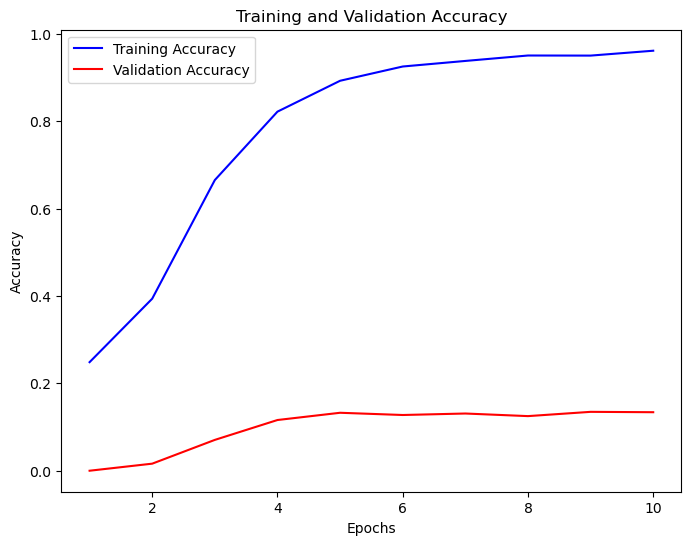

In [66]:
validation_file = './Data/valid.p'
print("Load Validation Data")
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
images_valid, labels_valid = valid['features'], valid['labels']

mask_0_to_8_valid = labels_valid <= 8
images_valid_filtered = images_valid[mask_0_to_8_valid]
labels_valid_filtered = labels_valid[mask_0_to_8_valid]

history_2 =   model.fit(images_train_filtered, labels_train_filtered, epochs=8, validation_data=(images_valid_filtered, labels_valid_filtered))

# Define the file name for saving the model
model_filename = 'Convolution_Model_F1__Ex_2_2'

# Save the model to a file
model.save(model_filename)

test_file = './Data/test.p'

with open(test_file, mode='rb') as f:
    test = pickle.load(f)
images_test, labels_test = test['features'], test['labels']
        
mask_test_0_to_8_test = labels_test <= 8
images_test = images_test[mask_test_0_to_8_test]
labels_test = labels_test[mask_test_0_to_8_test]



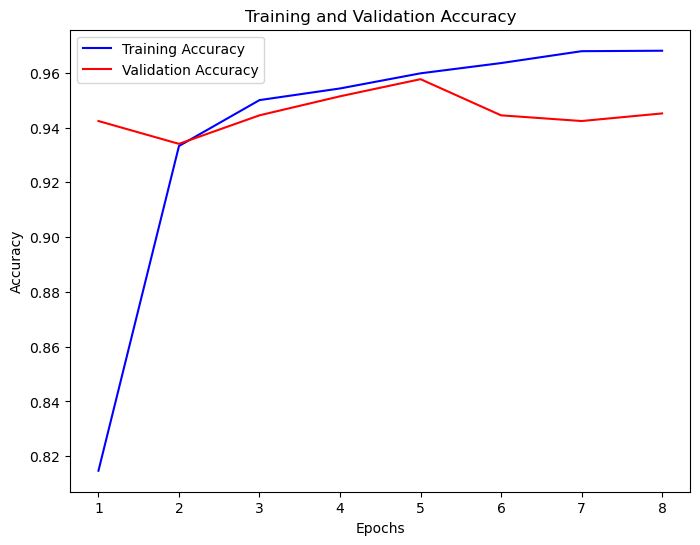

In [72]:
# Train the model and store the training history in a variable named "history"

# Extract accuracy values
train_accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']

# Plot accuracy
plt.figure(figsize=(8, 6))
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
test_loss, test_accuracy  = model.evaluate(images_test, labels_test) # ,f1_score

135/135 [==============================] - 13s 93ms/step - loss: 0.3981 - accuracy: 0.9125


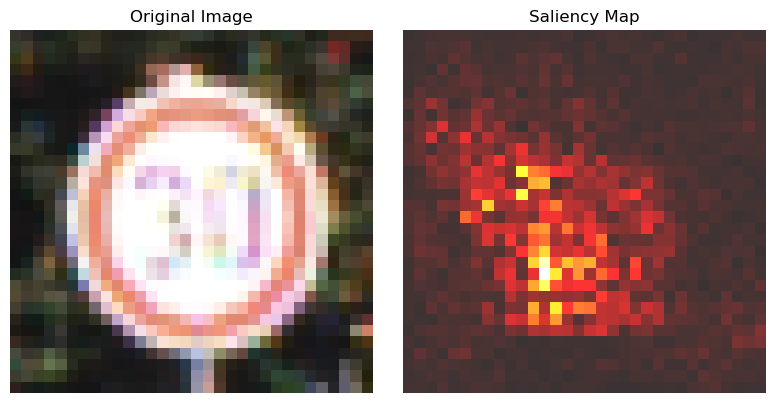

In [83]:
# Choose an index from your validation set
index = 8  # Replace with the index of the image you want to visualize

# Select an image from the validation set
selected_image = images_valid_filtered[index]  

# Convert the selected image to a format accepted by the model
input_image = np.expand_dims(selected_image, axis=0)  # Add batch dimension

# Define a function to compute gradients
@tf.function
def compute_gradients(input_image):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        predicted_class = tf.argmax(predictions, axis=1)
        predicted_output = predictions[0, predicted_class[0]]  # Access the predicted output directly
    gradients = tape.gradient(predicted_output, input_image)
    return gradients

# Compute gradients for the selected image
gradients = compute_gradients(tf.convert_to_tensor(input_image, dtype=tf.float32))

# Convert gradients to a saliency map
saliency_map = tf.abs(gradients)
saliency_map = tf.reduce_max(saliency_map, axis=-1)
saliency_map = saliency_map.numpy()[0]

# Normalize the saliency map
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Visualize the saliency map overlaid on the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(selected_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='hot', alpha=0.8)
plt.title('Saliency Map')
plt.axis('off')

plt.tight_layout()
plt.show()
